In [21]:
import importlib
from LSTM_returns.CORE import *
from data.CORE import *
import data, LSTM_returns, optimization

SOL_df = data.load_asset('SOLUSDT')
SOL_df = data.subset(SOL_df, start=pd.Timestamp('2021-01-01 08:00:00'), end=pd.Timestamp('2026-01-01'))
data.report_and_print_gaps(SOL_df)

SOL_df = data.add_returns(SOL_df)
print(SOL_df.columns)


Gap of 0 days 02:00:00 		 from 2021-02-11 05:00:00 to 2021-03-06 03:30:00
Gap of 0 days 03:00:00 		 from 2021-03-06 03:30:00 to 2021-04-20 04:30:00
Gap of 0 days 04:30:00 		 from 2021-04-20 04:30:00 to 2021-04-25 08:30:00
Gap of 0 days 05:00:00 		 from 2021-04-25 08:30:00 to 2021-08-13 06:30:00
Gap of 0 days 02:30:00 		 from 2021-08-13 06:30:00 to 2021-09-29 09:00:00
Gap of 0 days 01:30:00 		 from 2021-09-29 09:00:00 to 2023-03-24 14:00:00
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Return', 'Return_Target'],
      dtype='object')


In [19]:
# normalize all features but not targets
Fbutnt_df = SOL_df.copy()

numerical_columns = categorical_columns = "all"
exclude_columns = ['Return_Target']
Fbutnt_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Return']
Fbutnt_df, Fbutnt_columns = data.normalize_data(Fbutnt_df, exclude_columns=exclude_columns)

# fewer features (OHLC, Volume)
Fewerf_df = SOL_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Return_Target']].copy()

numerical_columns = categorical_columns = "all"
exclude_columns = ["Return_Target"]
Fewerf_features = ['Open', 'High', 'Low', 'Close', 'Volume']
Fewerf_df, Fewerf_columns = data.normalize_data(Fewerf_df, exclude_columns=exclude_columns)

# vs. normalize all features AND targets
Fandt_df = SOL_df.copy()

numerical_columns = categorical_columns = "all"
exclude_columns = []
Fandt_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Return']
Fandt_df, Fandt_columns = data.normalize_data(Fandt_df, exclude_columns=exclude_columns)


Fbutnt_columns, Fewerf_columns, Fandt_columns

({'Open': MinMaxScaler(),
  'High': MinMaxScaler(),
  'Low': MinMaxScaler(),
  'Close': MinMaxScaler(),
  'Volume': MinMaxScaler(),
  'Quote asset volume': MinMaxScaler(),
  'Number of trades': MinMaxScaler(),
  'Taker buy base asset volume': MinMaxScaler(),
  'Taker buy quote asset volume': MinMaxScaler(),
  'Return': MinMaxScaler(),
  'Return_Target': 'standard'},
 {'Open': MinMaxScaler(),
  'High': MinMaxScaler(),
  'Low': MinMaxScaler(),
  'Close': MinMaxScaler(),
  'Volume': MinMaxScaler(),
  'Return_Target': 'standard'},
 {'Open': MinMaxScaler(),
  'High': MinMaxScaler(),
  'Low': MinMaxScaler(),
  'Close': MinMaxScaler(),
  'Volume': MinMaxScaler(),
  'Quote asset volume': MinMaxScaler(),
  'Number of trades': MinMaxScaler(),
  'Taker buy base asset volume': MinMaxScaler(),
  'Taker buy quote asset volume': MinMaxScaler(),
  'Return': MinMaxScaler(),
  'Return_Target': MinMaxScaler()})

In [25]:
Fbutnt_df = data.train_test_split(Fbutnt_df)
Fewerf_df = data.train_test_split(Fewerf_df)
Fandt_df = data.train_test_split(Fandt_df)

episode_lengths = [5, 10, 30]
train_X_y_s = [
    [
        LSTM_returns.vectorize_train_data(df, features=features, episode_length=e) for e in episode_lengths
    ] for df, features in zip(
        [Fbutnt_df, Fewerf_df, Fandt_df],
        [Fbutnt_features, Fewerf_features, Fandt_features]
    )
]

In [31]:
import json
hyperparams_list = [
    {
        '__+ABD_exceptLast': False
    },
    {
        'LSTM_activation': 'relu'
    },
    {
        'optimizer': 'adam'
    },
    {
        'loss': 'mean_absolute_error'
    },
    {
        'loss': 'huber'
    },
    {
        'dropout': 0
    },
    {
        '__finalAct': 'sigmoid'
    },
    {
        '__penultRelu': True
    }
]

C:\Users\Ian Chen-Adamczyk\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1860/1860 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 1.5759e-04 - mae: 0.0089
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


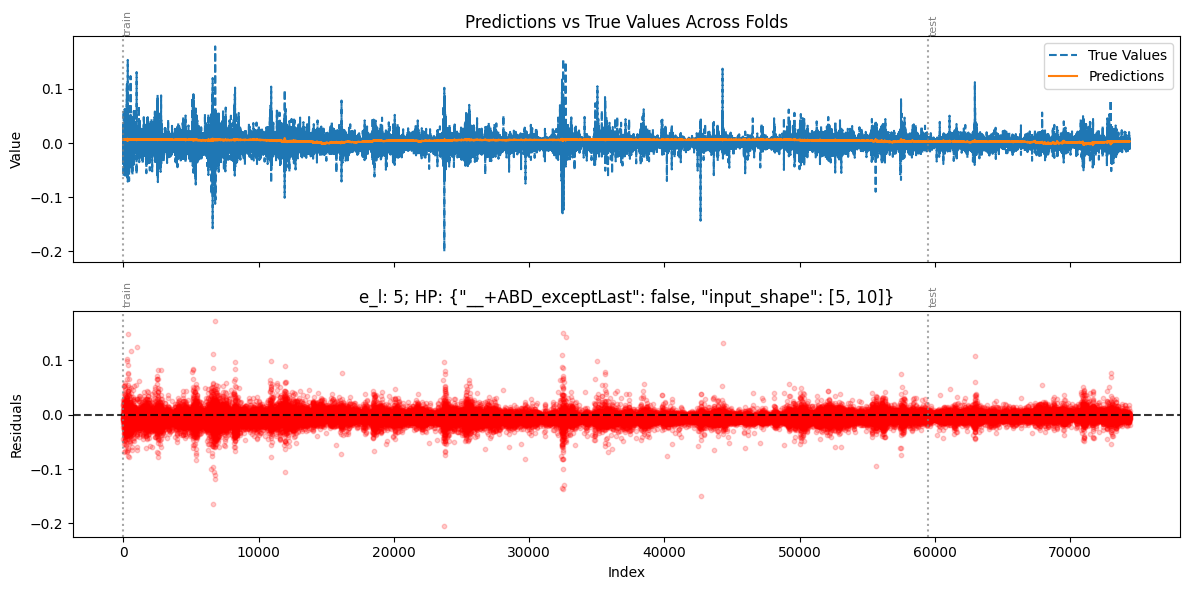

 301/1860 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0051 - mae: 0.0480

KeyboardInterrupt: 

In [ ]:
importlib.reload(LSTM_returns)

Fbutnt_LSTMs = []
for e_l, train_X_y in zip(episode_lengths, train_X_y_s[0]):
    for hyperparams in hyperparams_list:
        str_hyperparams = json.dumps(hyperparams)

        hyperparams['input_shape'] = train_X_y['train_X'].shape[1:]
        hyperparams['epochs'] = 1
        LSTM = LSTM_returns.create(hyperparams)
        LSTM_returns.train(LSTM, hyperparams, train_X_y, evaluateAtEnd=False)
        plt = LSTM_returns.all_folds_plot(LSTM, train_X_y)
        plt.title(f"EL: {e_l}; HP: {str_hyperparams}")
        plt.show()